## IMPORTS

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

Wait. What are we importing?

1. [**tensorflow**](https://www.tensorflow.org/) : google's machine learning framework (*numerical computation using data flow graphs*)
2. [**mnist**](http://yann.lecun.com/exdb/mnist/) : large database of *labeled* handwritten digits

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import helper
import importlib
importlib.reload(helper)

<module 'helper' from '/home/suriya/Documents/slides/swecha-ml/notebooks/helper.py'>

## DATA

In [14]:
mnist_data = input_data.read_data_sets("data/")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [15]:
batch_n = mnist_data.train.next_batch(batch_size=8)

In [16]:
type(batch_n)

tuple

In [17]:
batch_n

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32),
 array([1, 4, 8, 9, 7, 9, 6, 3], dtype=uint8))

In [18]:
batch_n[0].shape, batch_n[1].shape

((8, 784), (8,))

## Structure of data

- **(8,784)** : batch size (8), data dimension (784)
    - **784** = 28 * 28   
- **(8,)** : scalar label

### Access by index

In [19]:
print(type(batch_n))
print(batch_n[0].shape, type(batch_n[0]))
print(batch_n[0][0].shape, type(batch_n[0][0]))

<class 'tuple'>
(8, 784) <class 'numpy.ndarray'>
(784,) <class 'numpy.ndarray'>


In [10]:
image_0 = batch_n[0][0]
print(type(image_0))
print(image_0.shape)

<class 'numpy.ndarray'>
(784,)


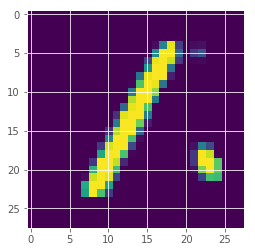

In [20]:
helper.show_mnist_image(plt, batch_n[0][0])

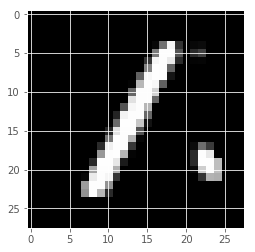

In [21]:
helper.show_mnist_image(plt, batch_n[0][0], cmap='gray')

## Is that a 1 or a 7?

In [22]:
label_0 = batch_n[1][0]
print(label_0)

1


## Can we display the whole batch?

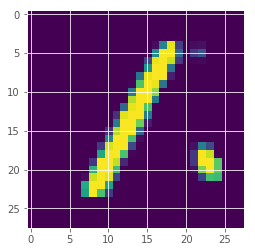

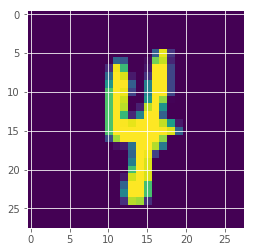

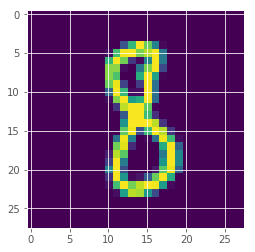

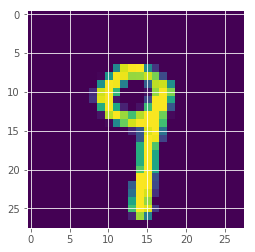

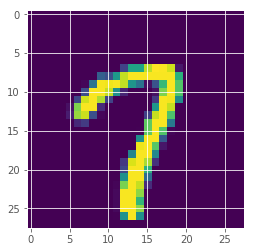

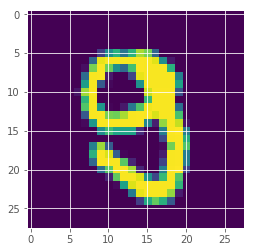

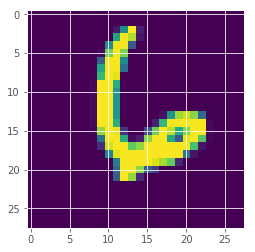

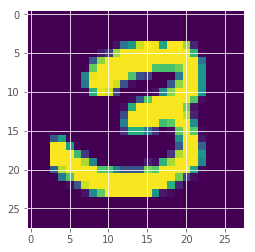

In [23]:
batch_images, batch_labels = batch_n[0], batch_n[1]
helper.show_mnist_image_multi(plt, batch_images)

## GRAPH

- **What is a graph?**

A computational graph or data-flow graph or simply, a graph, in tensorflow, is a network of interconnected nodes. A node represents an unique mathematical operation. The edges represent the multidimensional data arrays (tensors) passed through the nodes. The nodes perform transformations on the tensors being passed around.

- **Node**

Think of arithmetic operations like sum, product, etc,. When working on tensors, we perform linear algebraic operations, matrix multiplication (dot product), matrix/tensor tranformations, like transpose, reshape, etc,. 

- **Edge**

Tensors are multidimensional arrays, which have two significant properties : shape, value. The shape defines the container and value defines the data contained. Where do the tensors come from? From the dataset, in this case, MNIST images and labels. As an image of a digit flows through the graph, it gets transformed - streched, twisted, .., to yield us what we need. Which in this case, is the correct label (0-9). 

Ultimately, we can think of the graph that we are gonna define, as a mapping from image (of a digit) to the label. A non-linear function that maps a vector of shape (784,) to a scalar (0-9). 

## Building a graph in tensorflow

In [24]:
# clear default graph
tf.reset_default_graph()

### How to see the graph?

In [25]:
graph_ = tf.get_default_graph()
graph_.get_operations()

[]

We have defined any operations yet. Let's do that now

In [26]:
a = tf.placeholder(tf.float32) # scalar
b = tf.placeholder(tf.float32)
c = a*b # scalar multiplication

In [27]:
tf.get_default_graph().get_operations()

[<tf.Operation 'Placeholder' type=Placeholder>,
 <tf.Operation 'Placeholder_1' type=Placeholder>,
 <tf.Operation 'mul' type=Mul>]

Let's give them names.

In [28]:
# what do we do first?
#  clear the graph
tf.reset_default_graph()
a = tf.placeholder(tf.float32, name='a') # scalar
b = tf.placeholder(tf.float32, name='b')
c = a*b # scalar multiplication

In [29]:
tf.get_default_graph().get_operations()

[<tf.Operation 'a' type=Placeholder>,
 <tf.Operation 'b' type=Placeholder>,
 <tf.Operation 'mul' type=Mul>]

## How to use the graph?

1. Get your data ready
2. Start a tensorflow session : `tf.InteractiveSession()`
3. Execute graph using session variable
    - Feed data through `feed_dict`
    - fetch response from graph

**[1]**

In [30]:
data_a = 69
data_b = 0.2

**[2]**

In [31]:
sess = tf.InteractiveSession()

**[3], [4]**

In [32]:
response = sess.run(c, feed_dict = {
    a : data_a,
    b : data_b
})

In [33]:
response

13.8

## Can we get back to the problem now?

What were we doing though?

We were trying to build a graph that will output the correct label (0-9) 
given an image of a digit. We have the data ready. **[1]** is done!

Let's build the graph.

## Regression

**The what now?**

$$
logits = Wx + b\\
probs = softmax(logits)\\
label, \hat{y} = argmax(probs)\\
$$

**What is happening?**

Regression is a single-layer affine transformation. In the equation above, $logits=Wx + b$ refers to the regression part. What comes after, is the classification part. Let's travel backward.

- $ \hat{y} $ : label, whose value ranges from (0-9)
- $ probs $ : an array of length `10`, containing probabilities; scalars which range from 0 to 1. The value at index `0` in the array, represents the probability of the image being a `0`.
- $ logits $ : very similar to the `probs`, but `logits` contains the raw scores or unnormalized probabilities of the image being each of the label.

*Does that make sense?*

## A Graph for Regression

In [34]:
# clear the graph
tf.reset_default_graph()

Let's create placeholders. I have a convention for placeholders. I end them with `_`. What? you have a better idea?

- define batch_size

In [35]:
batch_size = 32

In [36]:
x_ = tf.placeholder(shape=[batch_size, 784], dtype=tf.float32, name='x')
y_ = tf.placeholder(shape=[batch_size, ], dtype=tf.int32, name='y')

In [37]:
print(x_)
print(y_)

Tensor("x:0", shape=(32, 784), dtype=float32)
Tensor("y:0", shape=(32,), dtype=int32)


## Do we need a batch_size?

In [38]:
# not really
tf.reset_default_graph()
x_ = tf.placeholder(shape=[None, None], dtype=tf.float32, name='x')
y_ = tf.placeholder(shape=[None, ], dtype=tf.int64, name='y')

In [39]:
print(x_)
print(y_)

Tensor("x:0", shape=(?, ?), dtype=float32)
Tensor("y:0", shape=(?,), dtype=int64)


> I think it's nice to have a little mystery.

## Parameters

In [40]:
W = tf.get_variable(name='W', shape=[784, 10], dtype=tf.float32,
                initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable(name='b', shape=[10], dtype=tf.float32,
                   initializer=tf.constant_initializer(0.))

- **W, b** are the parameters of the model
- **W** : weight 
- **b** : bias

## Operations

1. logits (matmul/dot product)
2. probabilities (softmax)
3. label (argmax)

**[1]**

In [41]:
# affine transformation
logits = tf.matmul(x_, W) + b

**[2]**

In [42]:
probs = tf.nn.softmax(logits)

**[3]**

In [43]:
predictions = tf.argmax(probs, axis=1)

That's it. We are done with the minimal sub-graph that is required for **forward propagation**. Let's try to execute it.

## Forward Propagation

1. Get your data ready
2. Start a tensorflow session : `tf.InteractiveSession()`
3. Execute graph using session variable
    - Feed data through `feed_dict`
    - fetch response from graph

In [44]:
images_n, labels_n = batch_n[0], batch_n[1]

### Sanity check

In [45]:
print(images_n.shape, labels_n.shape)
print('labels : ', labels_n)

(8, 784) (8,)
labels :  [1 4 8 9 7 9 6 3]


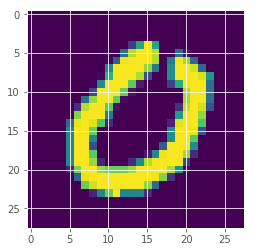

In [131]:
helper.show_mnist_image(plt, images_n[-1])

### Execute graph

In [46]:
# create session
sess = tf.InteractiveSession()

Whenever we are using parameters in our model, that need to initialized,
run `tf.global_variables_initializer()` in session.

In [47]:
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [48]:
predicted_labels = sess.run(predictions, feed_dict= {
    x_ : images_n,
    y_ : labels_n
})

In [49]:
predicted_labels

array([6, 0, 8, 1, 0, 0, 0, 1])

In [50]:
labels_n

array([1, 4, 8, 9, 7, 9, 6, 3], dtype=uint8)

## What did we miss?

> why kattappa killed bahubali?

The parameters of the model (W,b), are initialized randomly. 
We need the right values of parameters, that will maximize the accuracy - give us correct labels.
How do we find such parameters?

**We learn from data.**

1. We pass an image through the graph
2. Look at the performance
3. Measure the error ( compare `labels_n` with `probs` )
4. Use the error as gauge, to change the parameters just a little bit
5. Repeat for the next image (1)

## Performance Measure

We use the cost function or loss function, as measure of the performace. The `loss` is a scalar. We use a special loss function here (for classification problems), known as the **Cross Entropy**.

In [51]:
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_,
                                                     logits=logits)

Remember `y_`?

## Execute Loss

In [52]:
loss_value = sess.run(loss, feed_dict={
    x_ : images_n,
    y_ : labels_n
})

In [53]:
loss_value

array([ 2.76111054,  2.27143741,  1.94258213,  2.229743  ,  2.45285082,
        2.62512231,  2.41428185,  2.34059143], dtype=float32)

In [54]:
loss_value.shape

(8,)

## Learning

In [55]:
# take average of loss
batch_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_,
                                                     logits=logits)
loss = tf.reduce_mean(batch_loss)

In [56]:
print(batch_loss)
print(loss)

Tensor("SparseSoftmaxCrossEntropyWithLogits_1/SparseSoftmaxCrossEntropyWithLogits:0", shape=(?,), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)


In [57]:
# training operation
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
train_op = optimizer.minimize(loss)

**What did we do?**

1. Get average loss (scalar) from an array of losses of the whole batch
2. Create an optimizer which internally uses Gradient Descent method (you should read up on that.)
3. Define a training operation, which minimizes the loss

## Execute Training

Remember when we used `batch_n = mnist_data.train.next_batch(batch_size=8)` to get a small batch of size 8?

Now we need the whole training set to train the model. The training will happen iteratively, one batch at a time. We define a term `epochs`, which represents the total number of iterations, to run training.

1. Get a batch from mnist, using `mnist_data.train.next_batch`
2. Run `train_op` in session
3. Print `loss`
4. Repeat (1) until end of epochs

In [58]:
epochs = 100
for i in range(epochs):
    # get a batch from mnist
    images_i, labels_i = mnist_data.train.next_batch(32) # batch_size is 32
    _, loss_value = sess.run([train_op, loss], feed_dict= {
        x_ : images_i,
        y_ : labels_i
    })
    print('Iteration {} : loss = {}'.format(i, loss_value))

Iteration 0 : loss = 2.2148497104644775
Iteration 1 : loss = 2.3312249183654785
Iteration 2 : loss = 2.245910167694092
Iteration 3 : loss = 2.1576054096221924
Iteration 4 : loss = 2.041360855102539
Iteration 5 : loss = 2.035701036453247
Iteration 6 : loss = 1.9770705699920654
Iteration 7 : loss = 1.7502491474151611
Iteration 8 : loss = 1.7246334552764893
Iteration 9 : loss = 1.5338186025619507
Iteration 10 : loss = 1.654736042022705
Iteration 11 : loss = 1.6165482997894287
Iteration 12 : loss = 1.5488801002502441
Iteration 13 : loss = 1.5471186637878418
Iteration 14 : loss = 1.4041765928268433
Iteration 15 : loss = 1.3117499351501465
Iteration 16 : loss = 1.5073537826538086
Iteration 17 : loss = 1.2666707038879395
Iteration 18 : loss = 1.431739330291748
Iteration 19 : loss = 1.1525441408157349
Iteration 20 : loss = 1.4438265562057495
Iteration 21 : loss = 1.2740395069122314
Iteration 22 : loss = 1.107022762298584
Iteration 23 : loss = 1.2888743877410889
Iteration 24 : loss = 1.18607175

It would be nice to have a better measure of performance, that makes sense to us. 
How about accuracy?

## Accuracy

In [59]:
predictions

<tf.Tensor 'ArgMax:0' shape=(?,) dtype=int64>

In [60]:
y_

<tf.Tensor 'y:0' shape=(?,) dtype=int64>

In [61]:
# check if the labels match
correct_prediction = tf.equal(predictions, y_)
# calculate how many labels match, in a batch
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Train Again

In [62]:
epochs = 100
for i in range(epochs):
    # get a batch from mnist
    images_i, labels_i = mnist_data.train.next_batch(32) # batch_size is 32
    _, accuracy_value = sess.run([train_op, accuracy], feed_dict= {
        x_ : images_i,
        y_ : labels_i
    })
    print('Iteration {} : loss = {}%'.format(i, accuracy_value*100))

Iteration 0 : loss = 75.0%
Iteration 1 : loss = 84.375%
Iteration 2 : loss = 84.375%
Iteration 3 : loss = 78.125%
Iteration 4 : loss = 93.75%
Iteration 5 : loss = 90.625%
Iteration 6 : loss = 87.5%
Iteration 7 : loss = 81.25%
Iteration 8 : loss = 87.5%
Iteration 9 : loss = 78.125%
Iteration 10 : loss = 75.0%
Iteration 11 : loss = 93.75%
Iteration 12 : loss = 87.5%
Iteration 13 : loss = 81.25%
Iteration 14 : loss = 87.5%
Iteration 15 : loss = 81.25%
Iteration 16 : loss = 81.25%
Iteration 17 : loss = 84.375%
Iteration 18 : loss = 84.375%
Iteration 19 : loss = 78.125%
Iteration 20 : loss = 84.375%
Iteration 21 : loss = 81.25%
Iteration 22 : loss = 84.375%
Iteration 23 : loss = 81.25%
Iteration 24 : loss = 84.375%
Iteration 25 : loss = 90.625%
Iteration 26 : loss = 81.25%
Iteration 27 : loss = 87.5%
Iteration 28 : loss = 78.125%
Iteration 29 : loss = 84.375%
Iteration 30 : loss = 68.75%
Iteration 31 : loss = 84.375%
Iteration 32 : loss = 75.0%
Iteration 33 : loss = 87.5%
Iteration 34 : los

## Train some more

In [63]:
# recreate session
#  just for fun
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [64]:
epochs = 100000 # 3 more zeros
avg_acc = 0.
for i in range(epochs):
    # get a batch from mnist
    images_i, labels_i = mnist_data.train.next_batch(32) # batch_size is 32
    _, accuracy_value = sess.run([train_op, accuracy], feed_dict= {
        x_ : images_i,
        y_ : labels_i
    })
    avg_acc += accuracy_value
    if i and i % 10000 == 0:
        print('Iteration {} : loss = {}%'.format(i, (avg_acc*100)/10000 ))
        avg_acc = 0.

Iteration 10000 : loss = 91.1175%
Iteration 20000 : loss = 92.455%
Iteration 30000 : loss = 92.691875%
Iteration 40000 : loss = 92.89375%
Iteration 50000 : loss = 93.005%
Iteration 60000 : loss = 93.059375%
Iteration 70000 : loss = 93.1340625%
Iteration 80000 : loss = 93.1846875%
Iteration 90000 : loss = 93.2225%


That's great. But what did we miss?

The accuracy is pretty decent on the training data. But does it guarantee the performance on some other data? How can we check that?

- We train on training set and evaluate the accuracy on validation set.

## Validation

In [156]:
# recreate session
#  just for fun
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

epochs = 100000 # 3 more zeros
avg_acc = 0.
for i in range(epochs):
    # get a batch from mnist
    images_train_i, labels_train_i = mnist_data.train.next_batch(32) # batch_size is 32
    _, accuracy_value = sess.run([train_op, accuracy], feed_dict= {
        x_ : images_train_i,
        y_ : labels_train_i
    })
    avg_acc += accuracy_value
    if i and i % 10000 == 0:
        print('Iteration {} : accuracy = {}%'.format(i, (avg_acc*100)/10000 ))
        avg_acc = 0.
        # evaluation
        #  get validation set
        images_valid, labels_valid = mnist_data.validation.next_batch(1024)
        valid_acc = sess.run(accuracy, feed_dict={
            x_ : images_valid,
            y_ : labels_valid
        })
        print('\t Validation accuracy : {}%'.format(valid_acc*100))

Iteration 10000 : accuracy = 90.970625%
	 Validation accuracy : 91.11328125%
Iteration 20000 : accuracy = 92.2784375%
	 Validation accuracy : 93.26171875%
Iteration 30000 : accuracy = 92.5553125%
	 Validation accuracy : 93.9453125%
Iteration 40000 : accuracy = 92.76125%
	 Validation accuracy : 91.6015625%
Iteration 50000 : accuracy = 92.8375%
	 Validation accuracy : 91.89453125%
Iteration 60000 : accuracy = 92.9315625%
	 Validation accuracy : 92.3828125%
Iteration 70000 : accuracy = 93.02875%
	 Validation accuracy : 93.359375%
Iteration 80000 : accuracy = 93.0653125%
	 Validation accuracy : 93.06640625%
Iteration 90000 : accuracy = 93.1296875%
	 Validation accuracy : 92.7734375%


## Finally, 

In [158]:
image_n, label_n = mnist_data.test.next_batch(1)

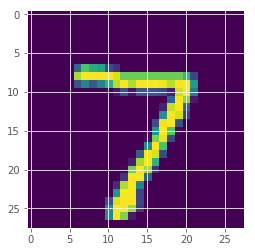

In [159]:
helper.show_mnist_image(plt, image_n[0])

In [160]:
print(label_n.shape, label_n)

(1,) [7]


In [165]:
prob_values, predicted_label = sess.run([probs, predictions], feed_dict={
    x_ : image_n
})
print('Probability Distribution : \n', prob_values[0])
print('Predicted Label : {}, with confidence of {}%'.
      format(predicted_label[0], prob_values[0][predicted_label[0]]*100))

Probability Distribution : 
 [  2.08494066e-06   5.04711019e-13   3.76748085e-06   4.83460166e-03
   1.71969873e-07   1.07542037e-05   3.63903976e-11   9.94486153e-01
   2.43600298e-05   6.38132682e-04]
Predicted Label : 7, with confidence of 99.4486153125763%


Predicted Label : **7**, with confidence of **99.44%**

# MIC DROP!

**Wait! Why do we have to settle for 93% accuracy?**

We don't have to.

## We need to go deeper!

![](deeper.jpg)

$$
Hidden\ Layer\ 1,\ h_1 = W_1x + b_1\\
logits = W_2h_1 + b_2\\
probs = softmax(logits)\\
label = argmax(probs)
$$

## Back to the Graph!

In [45]:
tf.reset_default_graph()
# placeholders
x_ = tf.placeholder(name='x', dtype=tf.float32, shape=[None, None])
y_ = tf.placeholder(name='y', dtype=tf.int64, shape=[None, ])
# parameters
#  define initalizer
xav = tf.contrib.layers.xavier_initializer

## Layer 1

In [46]:
W1 = tf.get_variable(name='W1', shape=[784, 1000], dtype=tf.float32,
                    initializer= xav())
b1 = tf.get_variable(name='b1', shape=[1000], dtype=tf.float32,
                    initializer=tf.constant_initializer(0.))
# operation
h1 = tf.nn.relu(tf.matmul(x_, W1) + b1)

## Layer 2

In [47]:
W2 = tf.get_variable(name='W2', shape=[1000, 10], dtype=tf.float32,
                    initializer= xav())
b2 = tf.zeros(name='b2', shape=[10], dtype=tf.float32,
                    initializer=tf.constant_initializer(0.))
logits = tf.nn.relu(tf.matmul(h1, W2) + b2)

## Training Operation

In [48]:
probs = tf.nn.softmax(logits)
predictions = tf.argmax(probs, axis=1)
correct_predictions = tf.equal(predictions, y_)
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
batch_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, 
                                                      labels=y_)
loss = tf.reduce_mean(batch_loss)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
train_op = optimizer.minimize(loss)

## Begin Training

In [ ]:
# recreate session
#  just for fun
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

epochs = 300000 # 3 more zeros
avg_acc = 0.
for i in range(epochs):
    # get a batch from mnist
    images_train_i, labels_train_i = mnist_data.train.next_batch(32) # batch_size is 32
    _, accuracy_value = sess.run([train_op, accuracy], feed_dict= {
        x_ : images_train_i,
        y_ : labels_train_i
    })
    avg_acc += accuracy_value
    if i and i % 10000 == 0:
        print('Iteration {} : accuracy = {}%'.format(i, (avg_acc*100)/10000 ))
        avg_acc = 0.
        # evaluation
        #  get validation set
        images_valid, labels_valid = mnist_data.validation.next_batch(1024)
        valid_acc = sess.run(accuracy, feed_dict={
            x_ : images_valid,
            y_ : labels_valid
        })
        print('\t Validation accuracy : {}%'.format(valid_acc*100))